## Smoking model

In [128]:
import numpy as np

# ---------------------
# 1. MODEL PARAMETERS
# ---------------------
T = 50             # Number of periods
delta_S = 0.1         # Depreciation factor for S
y = 10                # Income (or similar constant)
p = 7                 # Price or cost parameter for smoking

# Parameters for the utility function
a_sigma  = -0.5      # Increased weight on sigma effects (disease status)
a_0      = 0.1
a_c      = 0.6
a_sb     = 0.4
a_bsigma = -0.5
beta     = 0.99       # Increase discount factor so future matters more

# ---------------------
# 2. GRIDS
# ---------------------
# Grid for S (continuous, positive)
S_grid = np.linspace(0.1, 50, 50)
nS = len(S_grid)

# Grid for sigma (binary)
sigma_values = [0, 1]
nSigma = len(sigma_values)

# Grid for lambda (beliefs)
lambda_grid = np.linspace(-20, 20, 50)
nLambda = len(lambda_grid)

# ---------------------
# 3. CHOICE SET
# ---------------------
b_choices = [0, 1]  # e.g. 0 = no smoking, 1 = smoking

# ---------------------
# 4. UTILITY FUNCTION
# ---------------------
def utility(S, sigma, b):
    """
    Example utility function.
    """
    return np.exp(a_sigma * sigma) * (a_0 + (y - p * b)**a_c * (1 + S * b)**a_sb * (1 + sigma * b)**a_bsigma)

# ---------------------
# 5. TRANSITION FUNCTIONS
# ---------------------
def transition_S(S, b):
    """
    Transition for S: S evolves depending on b.
    """
    if b == 1:
        new_S = (1 - delta_S) * S + 1
    else:
        new_S = (1 - delta_S) * S
    # Keep S within grid bounds.
    new_S = max(new_S, S_grid[0])
    new_S = min(new_S, S_grid[-1])
    return new_S

# def pi_of_S(S):
#     """
#     Logistic-like function: pi(S) = 1 / (1 + exp(-S)).
#     """
#     return 1.0 / (1.0 + np.exp(-S))

def pi_of_S(S, k=0.2, S0=50):
    """
    A logistic function that maps S to (0,1) such that:
      - If S << S0, then pi(S) is near 0.
      - If S >> S0, then pi(S) is near 1.
      
    Parameters:
      k: controls the steepness of the curve.
      S0: the value of S at which pi(S)=0.5.
    """
    return 1.0 / (1.0 + np.exp(-k * (S - S0)))


def transition_lambda(lambda_val, S, sigma_lagged, sigma_current):
    """
    Update beliefs lambda according to:
      if sigma_lagged == 0:
          if sigma_current == 1:
              lambda_new = lambda + log(pi(S)/pi(0))
          else:
              lambda_new = lambda + log((1-pi(S))/(1-pi(0)))
      else:
          lambda_new = lambda
    """
    if sigma_lagged == 0:
        if sigma_current == 1:
            new_lambda = lambda_val + np.log(pi_of_S(S) / pi_of_S(0))
        else:
            new_lambda = lambda_val + np.log((1 - pi_of_S(S)) / (1 - pi_of_S(0)))
    else:
        new_lambda = lambda_val
    return new_lambda

def prob_sigma_next_is_one(sigma_current, lambda_val, S):
    """
    Returns the probability that sigma_{t+1} = 1.
    For sigma_current=1, assume sigma remains 1.
    For sigma_current=0, use a logistic-based formula incorporating lambda.
    """
    if sigma_current == 1:
        return 1.0
    else:
        # Example formulation: 
        # P(sigma_{t+1}=1 | sigma_t=0, lambda, S) = [pi(S)*exp(lambda) + pi(0)] / [1+exp(lambda)]
        num = pi_of_S(S) * np.exp(lambda_val) + pi_of_S(0)
        den = 1.0 + np.exp(lambda_val)
        output = num / den
        assert output <= 1 and output >=0, "det er ikke en sandsynlighed"
        return output

# ---------------------
# 6. VALUE FUNCTION & POLICY ARRAYS
# ---------------------
# Four-dimensional arrays: dimensions (T, nS, nSigma, nLambda)
V = np.zeros((T, nS, nSigma, nLambda))
Policy = np.zeros((T, nS, nSigma, nLambda), dtype=int)

# ---------------------
# 7. BACKWARD INDUCTION
# ---------------------
# --- Last Period (t = T-1): Agent maximizes immediate utility ---
t = T - 1
for i, S_val in enumerate(S_grid):
    for j, sigma_val in enumerate(sigma_values):
        for k, lambda_val in enumerate(lambda_grid):
            best_value = -np.inf
            best_choice = 0
            for b in b_choices:
                u = utility(S_val, sigma_val, b)
                if u > best_value:
                    best_value = u
                    best_choice = b
            V[t, i, j, k] = best_value
            Policy[t, i, j, k] = best_choice

# --- Earlier Periods: t = T-2 down to 0 ---
for t in reversed(range(T - 1)):
    for i, S_val in enumerate(S_grid):
        for j, sigma_val in enumerate(sigma_values):
            for k, lambda_val in enumerate(lambda_grid):
                best_value = -np.inf
                best_choice = 0
                for b in b_choices:
                    # Immediate utility
                    u = utility(S_val, sigma_val, b)
                    
                    # Next state for S (deterministic)
                    S_next = transition_S(S_val, b)
                    i_next = np.argmin(np.abs(S_grid - S_next))
                    
                    # Probability that sigma_{t+1}=1 (if current sigma==0)
                    p1 = prob_sigma_next_is_one(sigma_val, lambda_val, S_val)
                    
                    # Determine lambda transition for both possible sigma outcomes.
                    # For sigma_{t+1} = 1:
                    lambda_next_1 = transition_lambda(lambda_val, S_val, sigma_val, 1)
                    k_next_1 = np.argmin(np.abs(lambda_grid - lambda_next_1))
                    # For sigma_{t+1} = 0:
                    lambda_next_0 = transition_lambda(lambda_val, S_val, sigma_val, 0)
                    k_next_0 = np.argmin(np.abs(lambda_grid - lambda_next_0))
                    
                    # Next sigma: if sigma already 1, remains 1; if 0, can be 1 with probability p1, 0 with 1-p1.
                    # For sigma_{t+1}=1, we assign j_next_1 = 1, and for sigma_{t+1}=0, j_next_0 = 0.
                    j_next_1 = 1
                    j_next_0 = 0
                    
                    # Expected continuation value.
                    cont_val = (p1 * V[t+1, i_next, j_next_1, k_next_1] +
                                (1 - p1) * V[t+1, i_next, j_next_0, k_next_0])
                    
                    total_value = u + beta * cont_val
                    # print(f'b: {b} and t: {t} and lambda: {k} we have that total value is {total_value}')
                    if total_value > best_value:
                        best_value = total_value
                        best_choice = b

                V[t, i, j, k] = best_value
                Policy[t, i, j, k] = best_choice

# ---------------------
# 8. EXAMPLE USAGE
# ---------------------
# Retrieve the optimal decision and value at time t=0 for a given state:
t0 = 0
S_example = 0.0
sigma_example = 0
lambda_example = -0.0

# Find the nearest indices in the grids
i_example = np.argmin(np.abs(S_grid - S_example))
j_example = sigma_values.index(sigma_example)
k_example = np.argmin(np.abs(lambda_grid - lambda_example))

optimal_decision = Policy[t0, i_example, j_example, k_example]
optimal_value    = V[t0, i_example, j_example, k_example]

print(f"At t={t0}, S={S_example:.2f}, sigma={sigma_example}, lambda={lambda_example:.2f}:")
print(f"  Optimal decision b = {optimal_decision}")
print(f"  Value function     = {optimal_value:.4f}")


At t=0, S=0.00, sigma=0, lambda=-0.00:
  Optimal decision b = 0
  Value function     = 161.0428


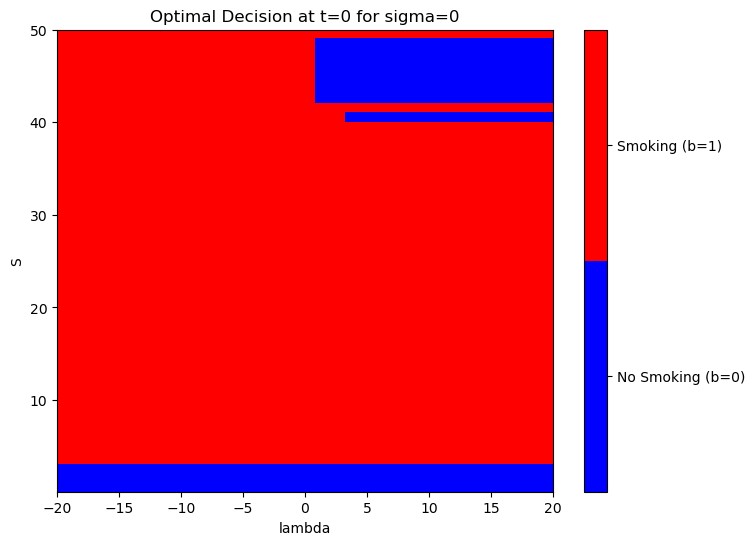

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming Policy, S_grid, lambda_grid, and sigma_values are defined from the previous code.
# Here, t0=0 and we consider sigma=0.
t0 = 1
sigma0_index = sigma_values.index(0)

# Create a 2D array to store the optimal decision for each (S, lambda) combination.
decision_grid = np.zeros((len(S_grid), len(lambda_grid)))

# Loop over all grid points for S and lambda.
for i, S_val in enumerate(S_grid):
    for k, lambda_val in enumerate(lambda_grid):
        decision_grid[i, k] = Policy[t0, i, sigma0_index, k]

# Define a discrete colormap with two colors.
# For example, blue for b=0 (no smoking) and red for b=1 (smoking).
cmap = ListedColormap(['blue', 'red'])
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot the decision grid using a heatmap.
plt.figure(figsize=(8, 6))
img = plt.imshow(decision_grid, extent=[lambda_grid[0], lambda_grid[-1], S_grid[0], S_grid[-1]],
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking (b=0)', 'Smoking (b=1)'])
plt.xlabel('lambda')
plt.ylabel('S')
plt.title('Optimal Decision at t=0 for sigma=0')
plt.show()


In [52]:
pi_of_S(0,k=1)

1.928749847963918e-22

In [50]:
pi_of_S(100)

0.9999546021312976

In [53]:
pi_of_S(100, k=1)

1.0

In [85]:
test_1 = prob_sigma_next_is_one(0, 10, 100)
print(test_1)

0.999909208384528
